# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.2 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.5 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-nkf71liy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-nkf71liy
  Resolved https://github.com/huggingface/accelerate to commit b30a349078d5301411e8af421720eaa60e984fa2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.22.0.dev0-py3-none-any.whl size=250102 sha256=39ce5ab6f61fa610025cd3763a99744e3a62c0767d2f5bd4aa5845ead659c1aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-e832xkow/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

In [9]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [10]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [11]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [12]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
      if  df['label'][d] not in labels:
          exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [13]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)

In [14]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)

# Model

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [16]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [18]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
import torch
torch.cuda.empty_cache()

In [20]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [21]:
train_r, test_r = train_test_split(df_r, test_size=0.2)
valid_r, test_r = train_test_split(test_r, test_size=0.5)

In [22]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [24]:
# define parameters
EPOCHS = 13

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [25]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.2756351065217404 accuracy 0.5285714285714286


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.0354904969533285 accuracy 0.08021978021978023

Epoch 2/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 1.0500246197508092 accuracy 0.6010989010989011


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 0.9654047687848409 accuracy 0.08296703296703296

Epoch 3/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.7519975532042352 accuracy 0.7241758241758242


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.0142032265663148 accuracy 0.08131868131868132

Epoch 4/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.4879313394950147 accuracy 0.8291208791208792


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.150920025507609 accuracy 0.08186813186813187

Epoch 5/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.2837407462331548 accuracy 0.9181318681318681


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.3941073536872863 accuracy 0.08241758241758242

Epoch 6/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.1664515753734138 accuracy 0.9516483516483516


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.4748243927955627 accuracy 0.08131868131868132

Epoch 7/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.09888222895505462 accuracy 0.9741758241758242


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.7323114673296611 accuracy 0.08351648351648351

Epoch 8/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.05886233960821604 accuracy 0.9829670329670329


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.8152005632718404 accuracy 0.08296703296703296

Epoch 9/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.028457002236360784 accuracy 0.9934065934065934


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9085858464241028 accuracy 0.08351648351648351

Epoch 10/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.015922022505516286 accuracy 0.9967032967032967


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9199727813402812 accuracy 0.08296703296703296

Epoch 11/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.010825696376789557 accuracy 0.9983516483516484


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.9468728661537171 accuracy 0.08131868131868132

Epoch 12/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.008178657664214833 accuracy 0.9989010989010989


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.966582437356313 accuracy 0.08296703296703296

Epoch 13/13
----------


  0%|          | 0/114 [00:00<?, ?it/s]

Train loss 0.007151792286956487 accuracy 0.9989010989010989


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.97125616868337 accuracy 0.08351648351648351



In [26]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [27]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.4625736410567871

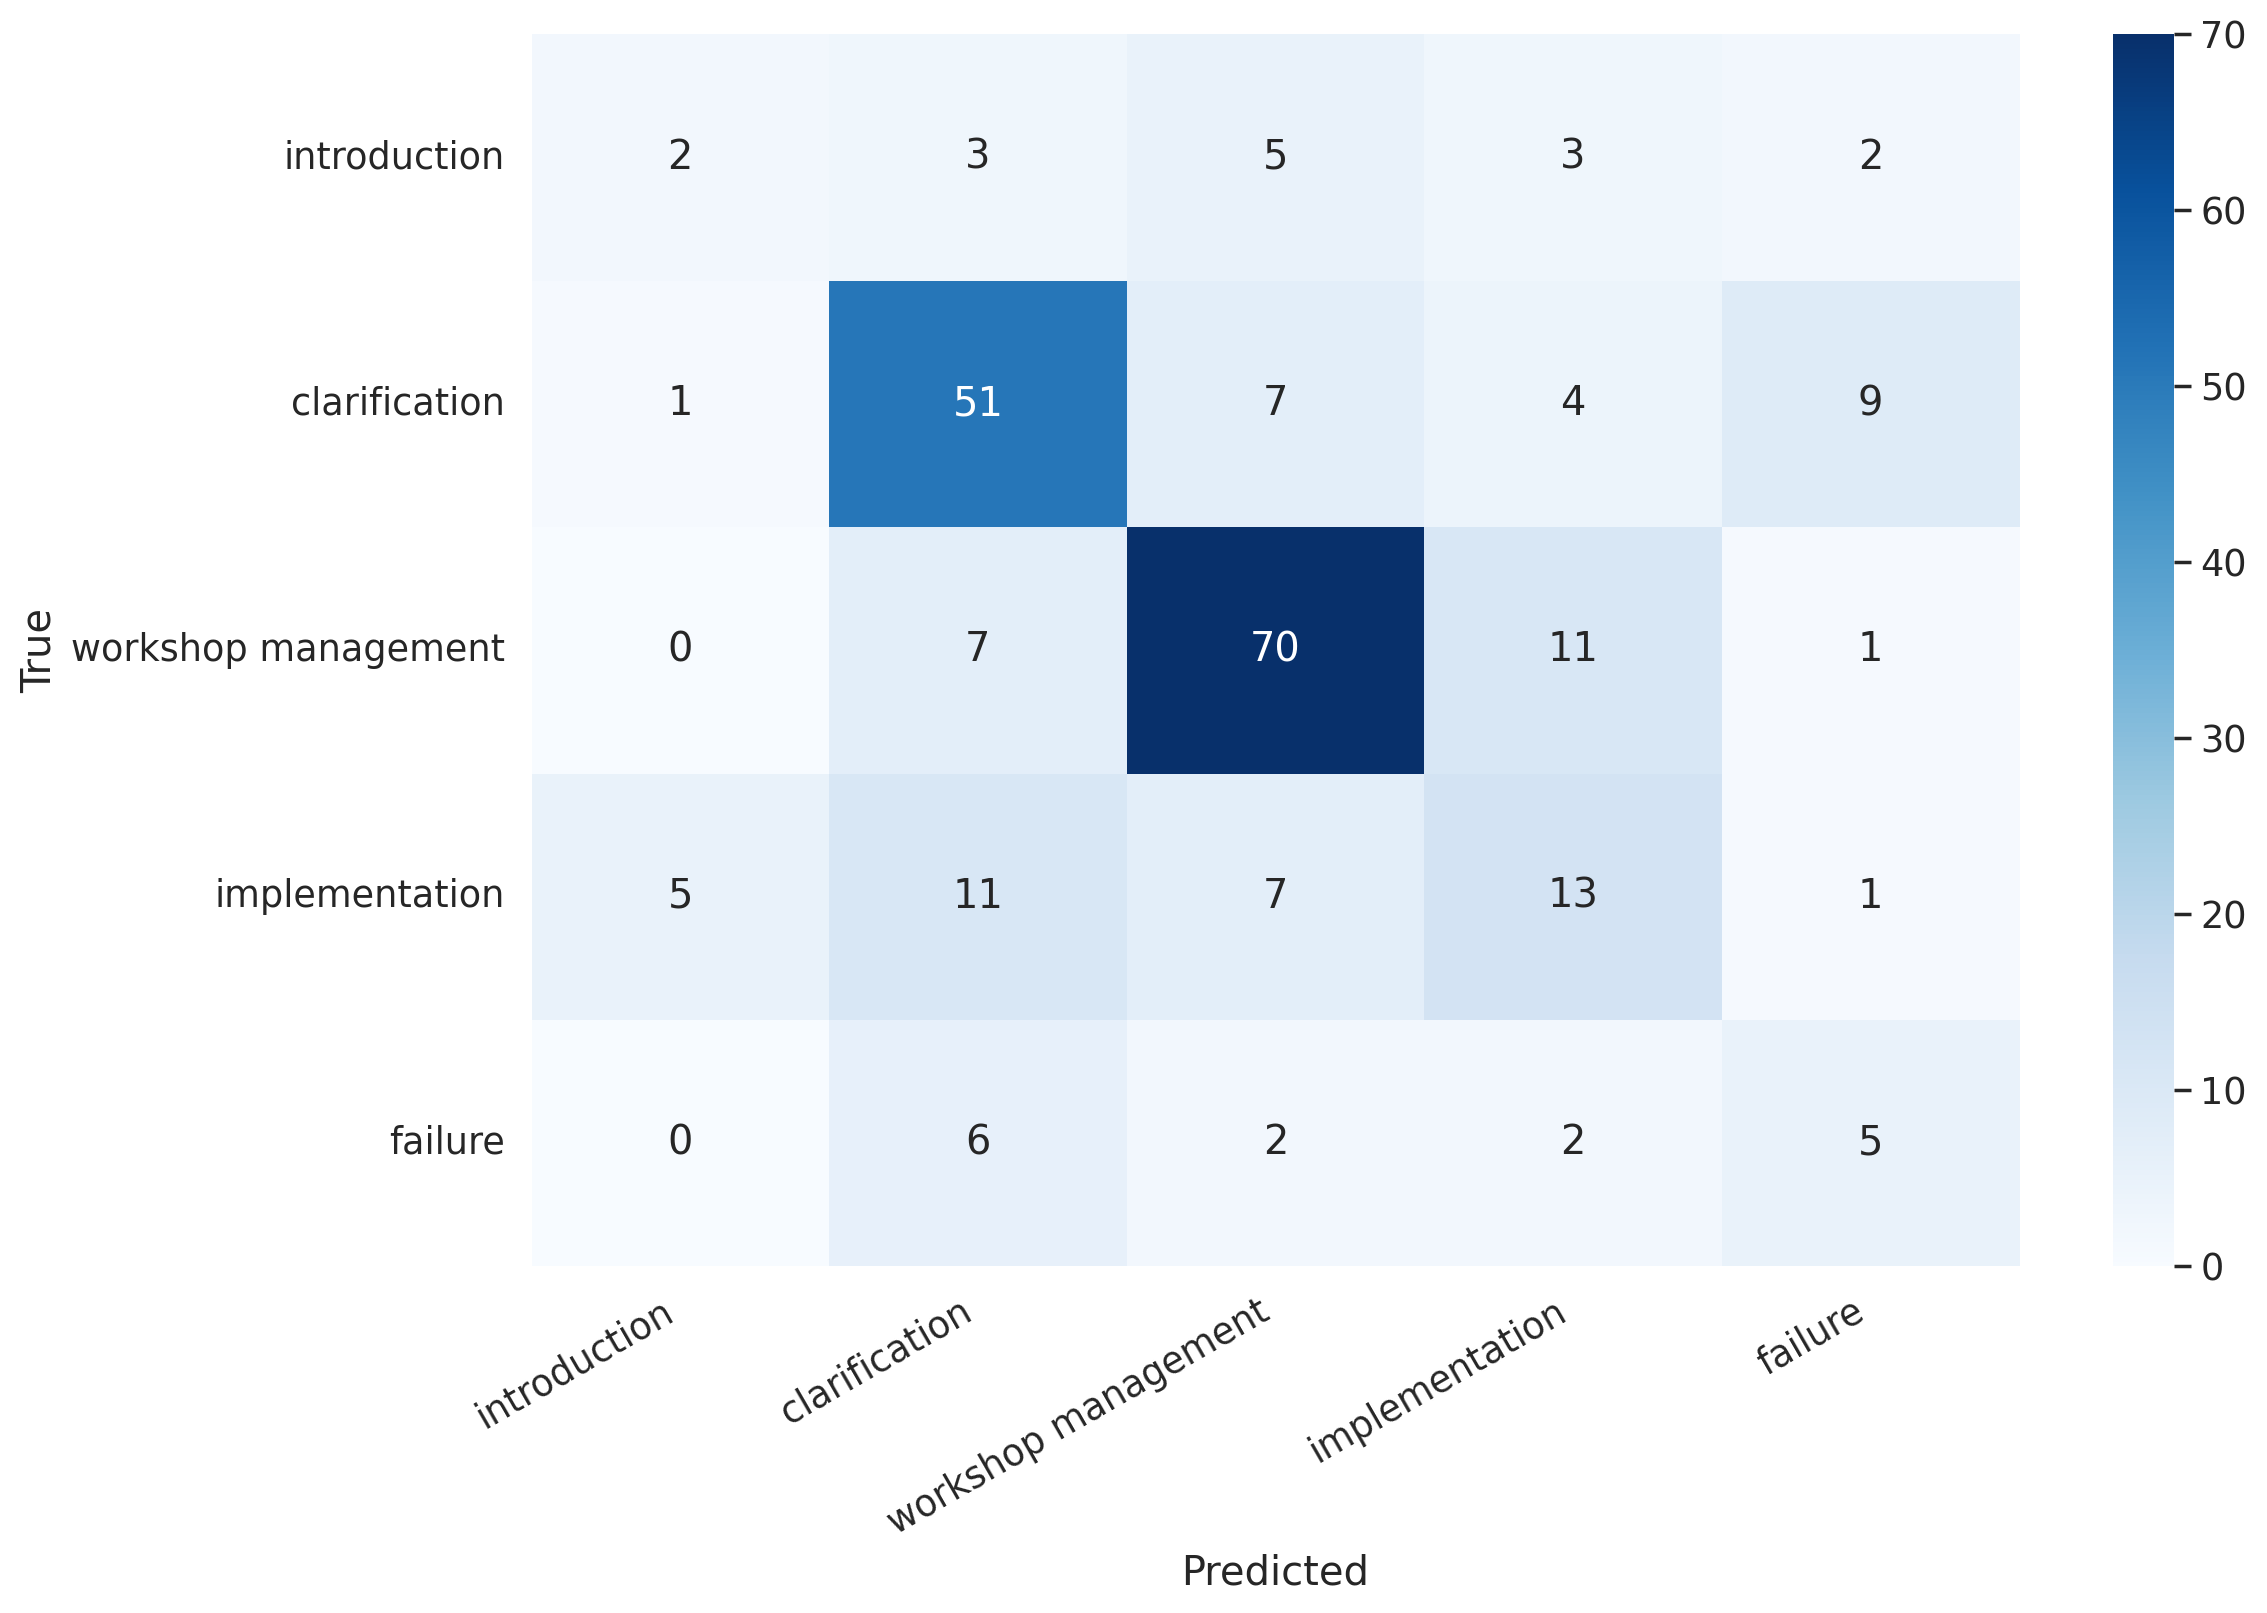

In [28]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [29]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.25      0.13      0.17        15
      clarification       0.65      0.71      0.68        72
workshop management       0.77      0.79      0.78        89
     implementation       0.39      0.35      0.37        37
            failure       0.28      0.33      0.30        15

           accuracy                           0.62       228
          macro avg       0.47      0.46      0.46       228
       weighted avg       0.61      0.62      0.61       228



# Participant

In [30]:
train_p, test_p = train_test_split(df_p, test_size=0.2)
valid_p, test_r = train_test_split(test_p, test_size=0.5)

In [31]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
# define parameters
EPOCHS = 13

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [34]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.5741548787106525 accuracy 0.27472527472527475


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5112784802913666 accuracy 0.03365384615384616

Epoch 2/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.5449666937628945 accuracy 0.2774725274725275


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5096331338087718 accuracy 0.03365384615384616

Epoch 3/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.5304970780571738 accuracy 0.2925824175824176


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.51893949508667 accuracy 0.03502747252747253

Epoch 4/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.5256343149876856 accuracy 0.27815934065934067


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5268212258815765 accuracy 0.03365384615384616

Epoch 5/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.4991770930342623 accuracy 0.3138736263736264


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.529200792312622 accuracy 0.03502747252747253

Epoch 6/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.5077579152453078 accuracy 0.3028846153846154


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.5136392811934154 accuracy 0.03502747252747253

Epoch 7/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.4562511470291641 accuracy 0.3385989010989011


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4937292834122975 accuracy 0.03502747252747253

Epoch 8/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.3827467921015981 accuracy 0.3701923076923077


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4282401303450267 accuracy 0.0418956043956044

Epoch 9/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.2852209472394251 accuracy 0.4677197802197803


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4506096243858337 accuracy 0.04601648351648352

Epoch 10/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.216038623353937 accuracy 0.49931318681318687


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.395966798067093 accuracy 0.04876373626373627

Epoch 11/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.1362418814019843 accuracy 0.5418956043956045


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.409712240099907 accuracy 0.05288461538461539

Epoch 12/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.0948114840538947 accuracy 0.5638736263736264


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4656454225381215 accuracy 0.0521978021978022

Epoch 13/13
----------


  0%|          | 0/91 [00:00<?, ?it/s]

Train loss 1.019424237392761 accuracy 0.5927197802197802


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4461609423160553 accuracy 0.05013736263736264



In [35]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [36]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.40981555256210617

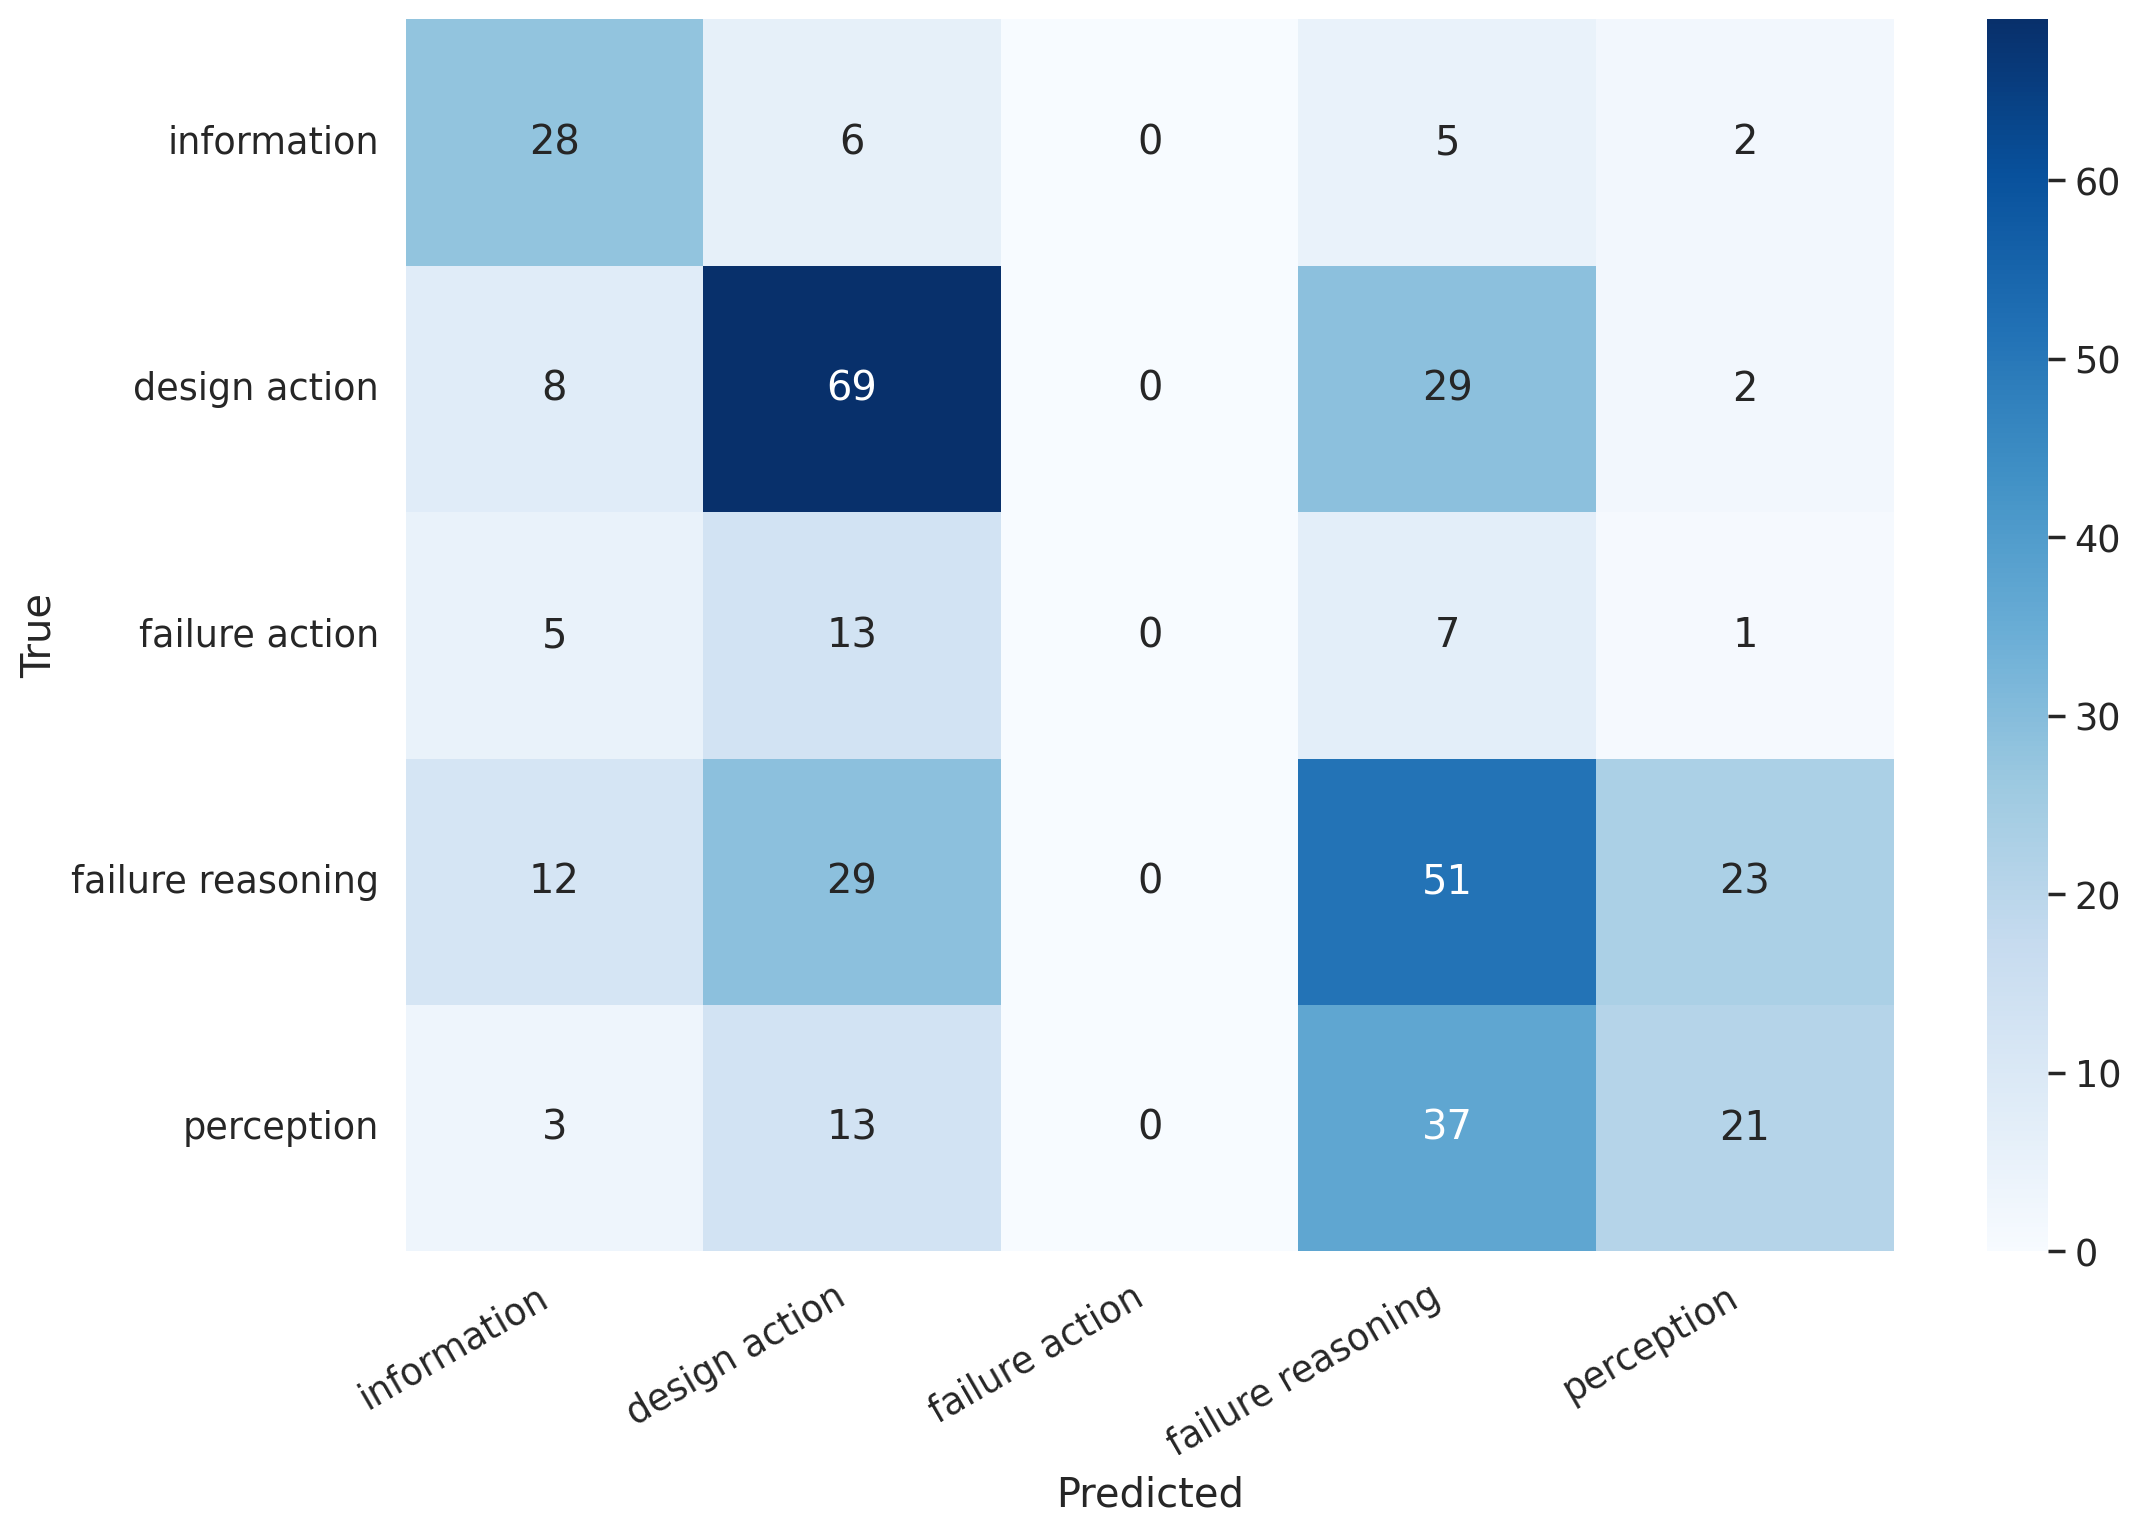

In [37]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [38]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.50      0.68      0.58        41
    design action       0.53      0.64      0.58       108
   failure action       0.00      0.00      0.00        26
failure reasoning       0.40      0.44      0.42       115
       perception       0.43      0.28      0.34        74

         accuracy                           0.46       364
        macro avg       0.37      0.41      0.38       364
     weighted avg       0.43      0.46      0.44       364



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
